In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import optuna
from jupyterthemes import jtplot
from mapie.regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap
from catboost import CatBoostRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error,r2_score

jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)
sns.set_theme()

Loading electricity demand data for Monterrey location retrieved from CENACE website

In [2]:
demandaMTY = pd.read_csv('df_fullMTY.csv')
demandaMTY['Fecha'] = pd.to_datetime(demandaMTY['Fecha'])
demandaMTY.set_index('Fecha', inplace=True)
demandaMTY = demandaMTY.loc[(demandaMTY.index >= '2018-01-02') & (demandaMTY.index <= '2022-12-31')]

Loading electricity price data retrieved also from CENACE website

In [3]:
pmlMTY = pd.read_csv('PMLMTY2016_2023.csv')
pmlMTY['Fecha'] = pd.to_datetime(pmlMTY['Fecha'])
pmlMTY.set_index('Fecha', inplace=True)
pmlMTY = pmlMTY.loc[(pmlMTY.index >= '2018-01-02') & (pmlMTY.index <= '2022-12-31')]
pmlMTY.rename(columns={'Precio marginal local ($/MWh)':'PML'}, inplace=True)

As obtained from electricity price data analysis, it will be used the lags from 14, 15 and 16 days prior.

In [4]:
pmlMTYlag = pmlMTY.copy()
pmlMTYlag['PMLlag14'] = pmlMTYlag['PML'].shift(6)#14
pmlMTYlag['PMLlag15'] = pmlMTYlag['PML'].shift(13)#15
pmlMTYlag['PMLlag16'] = pmlMTYlag['PML'].shift(20)#16

Temperature variations ranging from 2018 thru 2022 fro Monterrey were obtained from NOAA (https://www.ncei.noaa.gov/cdo-web/)

In [5]:
tempMTY = pd.read_csv('WeatherMTY2017_2023.csv')
tempMTY['DATE'] = pd.to_datetime(tempMTY['DATE'])
tempMTY.set_index('DATE', inplace=True)
tempMTY = tempMTY.loc[(tempMTY.index >= '2018-01-02') & (tempMTY.index <= '2022-12-31')]
tempMTY.drop(columns=['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION','PRCP_ATTRIBUTES','TAVG_ATTRIBUTES','TMAX_ATTRIBUTES','TMIN_ATTRIBUTES', 'PRCP','TMAX','TMIN'], inplace=True)

Contatenate all data into a single dataframe

In [6]:
demandaMTY_full = demandaMTY.copy()
demandaMTY_full = pd.concat([demandaMTY_full,pmlMTYlag, tempMTY], axis=1)

Create function to create features that will be used in Catboost model

In [7]:
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    return df

Define function to create lags features for electricity demand data

In [8]:
def add_lags(df):
    df['lag1'] = df[' Energia (MWh) '].shift(1)
    df['lag7'] = df[' Energia (MWh) '].shift(7)
    return df

Create function to calculate statistic metrics for the model

In [9]:
def calculate_model_accuracy_metrics(actual, predicted):
    mape = mean_absolute_percentage_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    return mape*100,mae,mse,rmse,r2

Create function to calculate Conformal Prediction metrics

In [10]:
def calculate_metricsforCP(y_true, lower_bound, upper_bound, alpha=0.05):

    coverage_probability_conformal = np.mean((y_true >= lower_bound) & (y_true <= upper_bound))
    coverage_indicator = ((lower_bound <= y_true) & (y_true <= upper_bound)).astype(int)

    validity = abs(coverage_probability_conformal - alpha)
    sharpness = np.mean(upper_bound - lower_bound)
    interval_score = sharpness + (1 / len(y_true)) * coverage_indicator.sum()

    return validity,sharpness,interval_score

Prepare data for Catboost model

In [11]:
dataforcatboost = demandaMTY_full.copy()

train = dataforcatboost.loc[(dataforcatboost.index >= '2018-01-02') & (dataforcatboost.index <= '2021-12-31')]
test = dataforcatboost.loc[(dataforcatboost.index >= '2022-01-01') & (dataforcatboost.index <= '2022-12-31')]

traincatboost = create_features(train)
testcatboost = create_features(test)

traincatboost = add_lags(traincatboost)
testcatboost = add_lags(testcatboost)

FEATURES = ['dayofweek','lag1','lag7','PMLlag14','PMLlag15','PMLlag16','TAVG']
TARGET = [' Energia (MWh) ']

X_train = traincatboost[FEATURES]
y_train = traincatboost[TARGET]

X_test = testcatboost[FEATURES]
y_test = testcatboost[TARGET]

Plotting electricity demand data showing the train and test sets

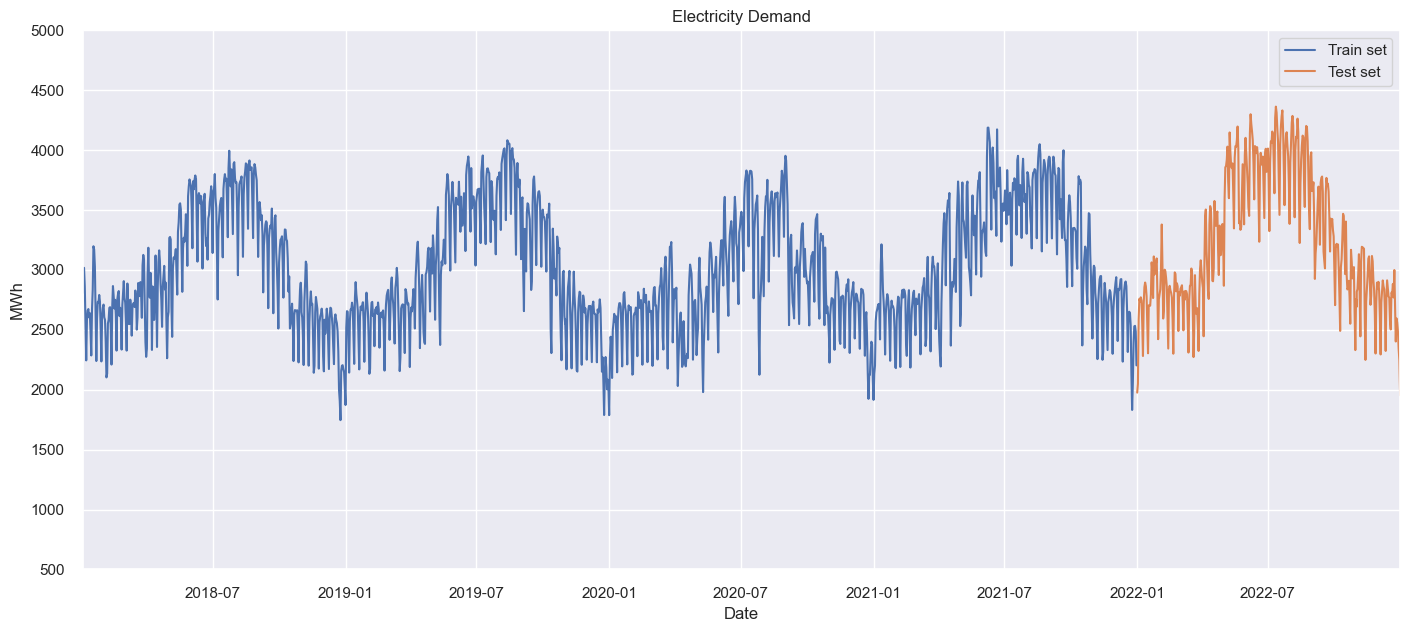

In [12]:
plt.figure(figsize=(17, 7))
plt.plot(X_train.index, y_train.values, label="Train set")
plt.plot(X_test.index, y_test.values, label="Test set")
plt.title("Electricity Demand")
plt.xlabel("Date")
plt.ylabel("MWh")
plt.xlim([X_train.index.min(), X_test.index.max()])
plt.ylim([500, 5000])
plt.legend()
plt.show();

****************** Catboost model definition *******************

Perform grid search to find best parameters for the model using optuna

In [13]:
# from sklearn.preprocessing import StandardScaler

# X_train_scaled = X_train.copy()
# X_train_scaled = X_train_scaled.fillna(0)
# y_train_scaled = y_train.copy()
# y_train_scaled = y_train_scaled.fillna(0)

# scaler = StandardScaler()
# X_train_optuna = scaler.fit_transform(X_train_scaled)
# y_train_optuna = scaler.fit_transform(y_train_scaled)
# X_train_optuna_final = X_train_optuna[0:1461]
# y_train_optuna_final = y_train_optuna[0:1461]
# X_val_optuna_final = X_train_optuna[1461:]
# y_val_optuna_final = y_train_optuna[1461:]

In [14]:
# def objective(trial):
#     params = {
#         "iterations": 1000,
#         "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.2, log=True),
#         "depth": trial.suggest_int("depth", 1, 5),
#         "subsample": trial.suggest_float("subsample", 0.1, 0.3),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.2, 0.5),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 20),
#     }

#     model = CatBoostRegressor(**params, silent=True)
#     model.fit(X_train_optuna_final, y_train_optuna_final)
#     predictions = model.predict(X_val_optuna_final)
#     rmse = mean_squared_error(y_val_optuna_final, predictions, squared=False)
#     return rmse

In [15]:
# import warnings
# warnings.filterwarnings("ignore")

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=30)
# print('Best hyperparameters:', study.best_params)
# print('Best RMSE:', study.best_value)

Catboost model definition using the best parameters

In [16]:
#Best hyperparameters from optuna: {'learning_rate': 0.1360103926557142, 
#                                   'depth': 1, 
#                                   'subsample': 0.142, 
#                                   'colsample_bylevel': 0.46, 
#                                   'min_data_in_leaf': 7}
reg = CatBoostRegressor(learning_rate= 0.13,
                        depth= 1,
                        subsample= 0.142,
                        colsample_bylevel= 0.46,
                        min_data_in_leaf= 7,
                        random_state = 101
                         )
reg.fit(X_train, y_train,
eval_set=[(X_train, y_train), (X_test, y_test)],
verbose=200)

0:	learn: 500.0667250	test: 500.0667250	test1: 612.7817684	best: 612.7817684 (0)	total: 115ms	remaining: 1m 54s
200:	learn: 146.9917571	test: 146.9917571	test1: 147.5910572	best: 147.5765112 (197)	total: 322ms	remaining: 1.28s
400:	learn: 138.5641027	test: 138.5641027	test1: 137.9154581	best: 137.9154581 (400)	total: 486ms	remaining: 725ms
600:	learn: 135.4825769	test: 135.4825769	test1: 135.7219328	best: 135.6897910 (586)	total: 608ms	remaining: 404ms
800:	learn: 133.6220767	test: 133.6220767	test1: 134.6313159	best: 134.5284813 (792)	total: 728ms	remaining: 181ms
999:	learn: 132.2633665	test: 132.2633665	test1: 133.6726541	best: 133.6660153 (996)	total: 848ms	remaining: 0us

bestTest = 133.6660153
bestIteration = 996

Shrink model to first 997 iterations.


Calculate the prediction for the test set

In [17]:
y_pred = reg.predict(X_test)

Calculate the Shapley values for the model

In [18]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(reg)
shap_values = explainer(X_train)
i_med = np.argsort(y_pred)[len(y_pred)//2]

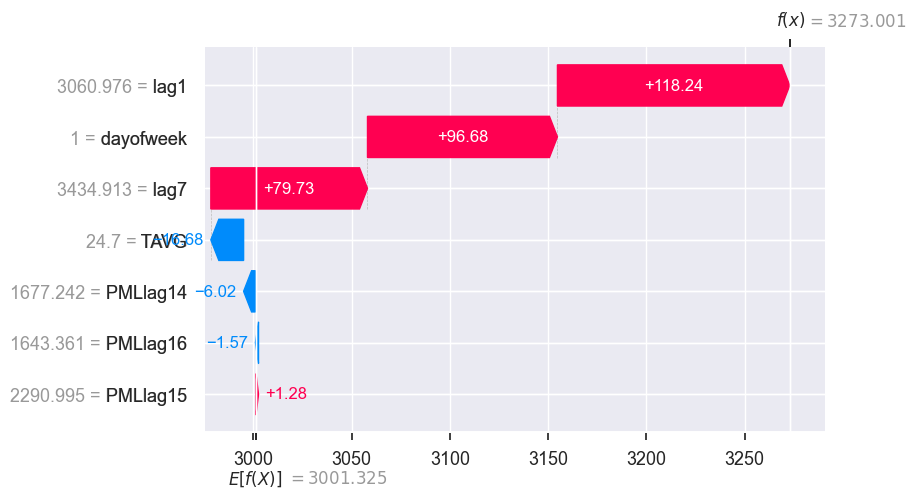

In [19]:
explainer.expected_value, np.mean(y_train)
shap.plots.waterfall(shap_values[i_med], max_display=99, show=False)
plt.gcf()
plt.show();

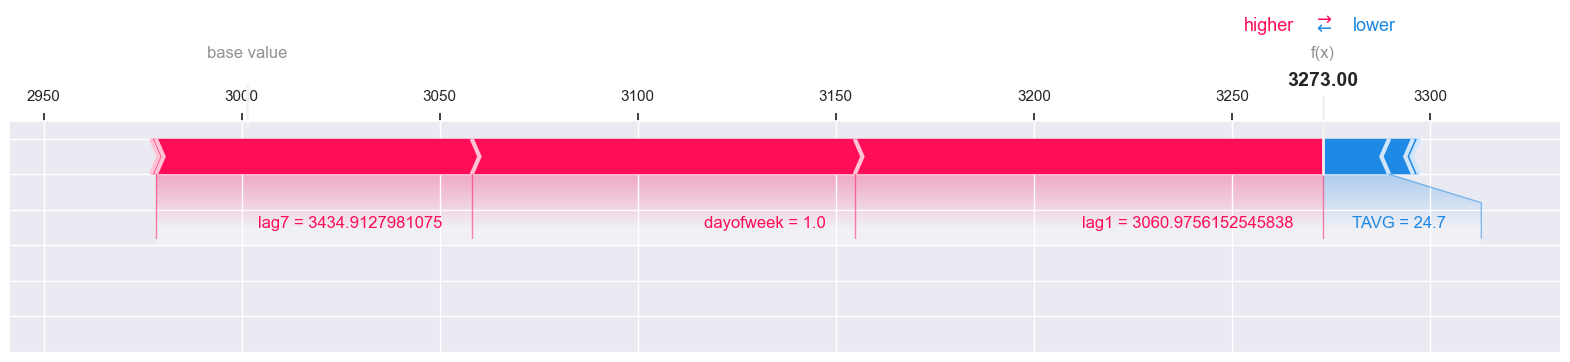

In [20]:
shap.plots.force(shap_values[i_med], show=False, matplotlib=True)
plt.gcf()
plt.show();

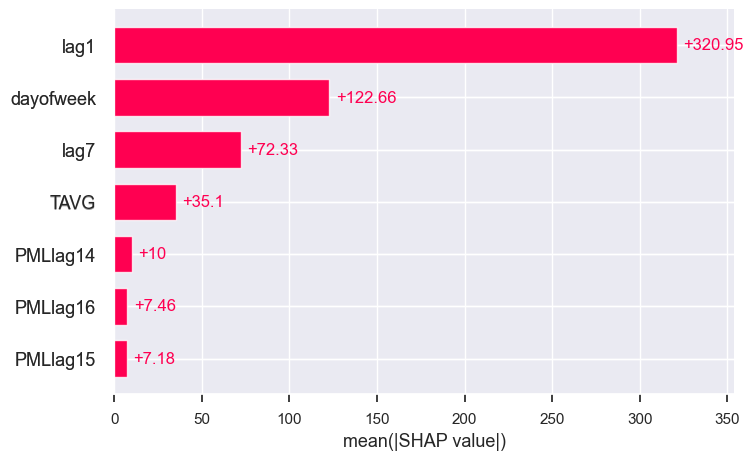

In [21]:
shap.plots.bar(shap_values, max_display=99, show=False)
plt.gcf()
plt.show()

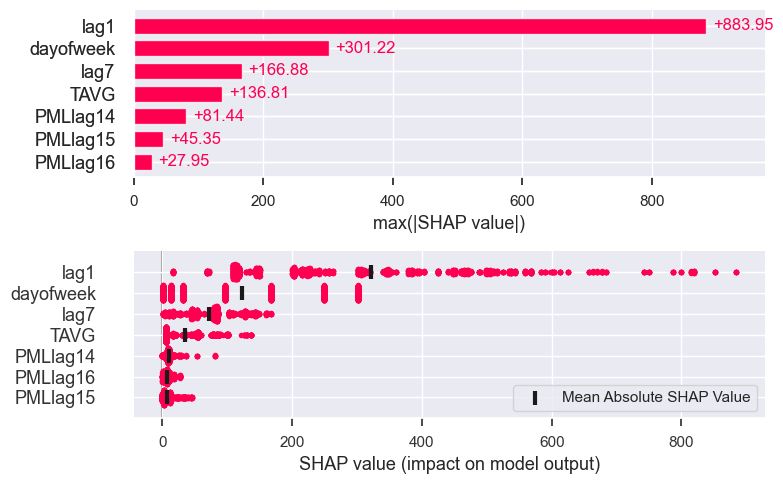

In [23]:
plt.subplot(2, 1, 1)
plt.gcf()
shap.plots.bar(shap_values.abs.max(0), max_display=99, show=False)
plt.subplot(2, 1, 2)
shap.plots.beeswarm(
    shap_values.abs, color="shap_red", max_display=99, show=False, plot_size=None
)
ax = plt.gca()
masv = {}
for feature in ax.get_yticklabels():
    name = feature.get_text()
    col_ind = X_train.columns.get_loc(name)
    mean_abs_sv = np.mean(np.abs(shap_values.values[:, col_ind]))
    masv[name] = mean_abs_sv
ax.scatter(
    masv.values(),
    [i for i in range(len(X_train.columns))],
    zorder=99,
    label="Mean Absolute SHAP Value",
    c="k",
    marker="|",
    linewidths=3,
    s=100,
)
ax.legend(frameon=True)
plt.tight_layout()
plt.show();

Plotting prediction values vs real values of test set

In [24]:
fig, (ax1) = plt.subplots(figsize=(18,8),sharex=True)
fig.suptitle('Electricity demand forecast for MTY using CatBoost Model', fontsize=16)
ax1.plot(y_test.index, y_test.values, marker='o', label="True values", color='black')
ax1.plot(y_test.index, y_pred, label="Predicted values", color='red')
ax1.legend(loc='upper left', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_ylim([200, 5000])
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('MWh', fontsize=16)
ax1.set_xlim([datetime.date(2022, 1, 1), datetime.date(2023,1,1)])

(18993.0, 19358.0)

Calculate premiliary metrics for the model

In [25]:
mape,mae,mse,rmse,r2 = calculate_model_accuracy_metrics(y_test.values,y_pred)
mape,mae,mse,rmse,r2

(3.2808189860173065,
 104.78615625131216,
 17866.60316019179,
 133.66601348208073,
 0.9433284935209785)

Performing isotonic regression to calibrate the model

In [26]:
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
y_testreshape = y_test.copy()
y_testreshape = y_testreshape.values.reshape(-1)
ir = IsotonicRegression(out_of_bounds='clip')
ir.fit(y_pred, y_testreshape)
y_pred_calibrated_iso = ir.predict(y_pred)

Plot isotonic regression calibration

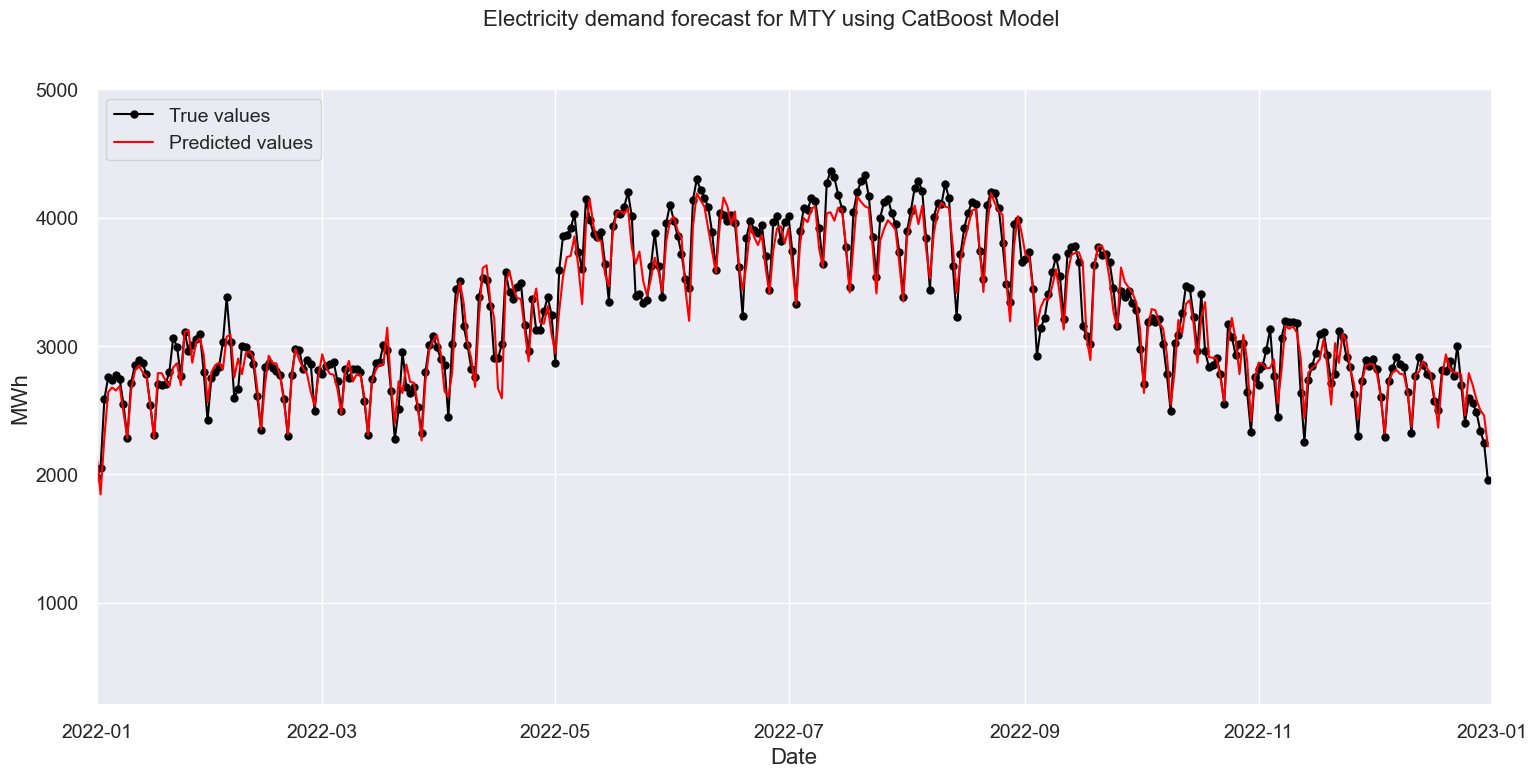

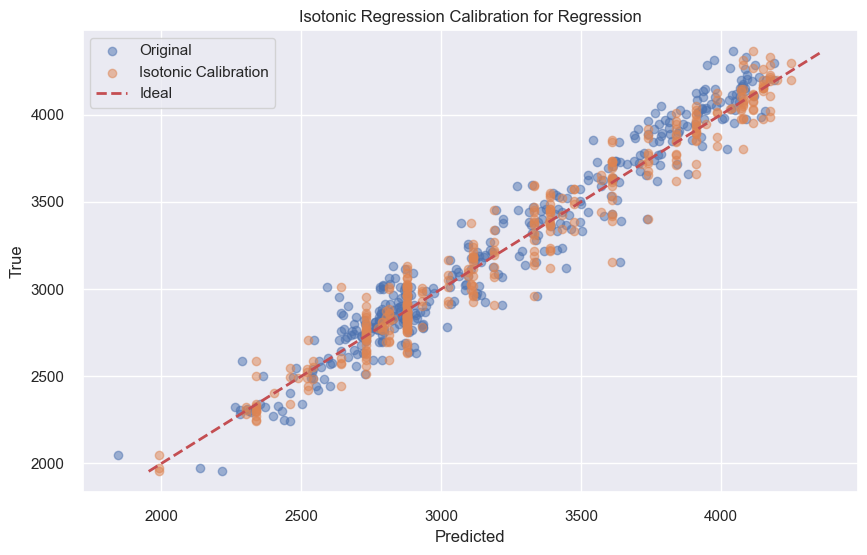

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_testreshape, alpha=0.5, label='Original')
plt.scatter(y_pred_calibrated_iso, y_testreshape, alpha=0.5, label='Isotonic Calibration')
plt.plot([y_testreshape.min(), y_testreshape.max()], [y_testreshape.min(), y_testreshape.max()], 'r--', lw=2, label='Ideal')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Isotonic Regression Calibration for Regression')
plt.legend()
plt.show()

Calculate Conformal Prediction intervals using MAPIE

In [28]:
alpha = 0.05
gap = 1

mapie_cv = BlockBootstrap(n_blocks=10, overlapping=True, random_state=42)

mapie_enbpi = MapieTimeSeriesRegressor(
    reg, method="enbpi", cv=mapie_cv, agg_function="mean", n_jobs=-1
)

In [29]:
mapie_enbpi = mapie_enbpi.fit(X_train, y_train.values.ravel())
y_pred_npfit, y_pis_npfit = mapie_enbpi.predict(
    X_test.values, alpha=alpha, ensemble=True, optimize_beta=True
)
coverage_npfit = regression_coverage_score(
    y_pred_calibrated_iso, y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)
width_npfit = regression_mean_width_score(y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0])

0:	learn: 500.0667250	total: 987us	remaining: 986ms
1:	learn: 461.9196999	total: 2ms	remaining: 999ms
2:	learn: 430.6503092	total: 3.3ms	remaining: 1.1s
3:	learn: 402.5904686	total: 4.47ms	remaining: 1.11s
4:	learn: 379.4021614	total: 5.7ms	remaining: 1.13s
5:	learn: 361.0283699	total: 6.78ms	remaining: 1.12s
6:	learn: 344.0603563	total: 8.06ms	remaining: 1.14s
7:	learn: 328.5615933	total: 9.34ms	remaining: 1.16s
8:	learn: 314.0483365	total: 10.4ms	remaining: 1.14s
9:	learn: 307.9424456	total: 11.4ms	remaining: 1.13s
10:	learn: 295.2370341	total: 12.4ms	remaining: 1.12s
11:	learn: 285.2082732	total: 13.4ms	remaining: 1.1s
12:	learn: 277.4350587	total: 14.5ms	remaining: 1.1s
13:	learn: 269.6128557	total: 15.6ms	remaining: 1.1s
14:	learn: 264.3859665	total: 16.6ms	remaining: 1.09s
15:	learn: 258.1185723	total: 17.7ms	remaining: 1.09s
16:	learn: 251.5785248	total: 18.6ms	remaining: 1.07s
17:	learn: 246.5039676	total: 19.7ms	remaining: 1.07s
18:	learn: 241.0560967	total: 21.3ms	remaining: 

c:\Users\jorge\AppData\Local\Programs\Python\Python39\lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


Plotting forecast with Conformal Prediction intervals

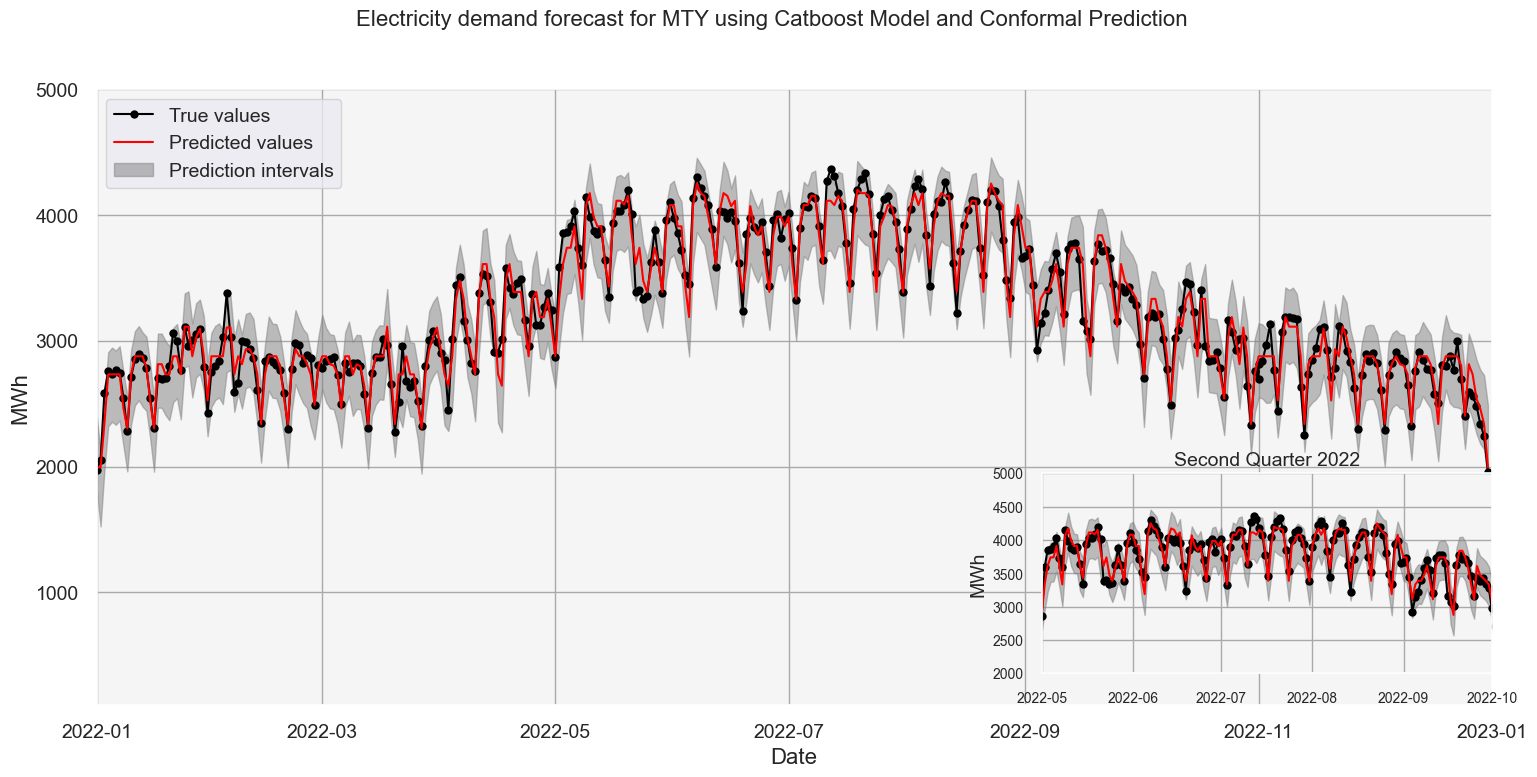

In [30]:
import matplotlib as mpl
mpl.rcParams['grid.color'] = 'darkgray'
fig, (ax1) = plt.subplots(figsize=(18,8),sharex=True)
fig.suptitle('Electricity demand forecast for MTY using Catboost Model and Conformal Prediction', fontsize=16)
ax1.set_facecolor('whitesmoke')
ax1.plot(y_test.index, y_test.values, marker='o', label="True values", color='black')
ax1.plot(y_test.index, y_pred_calibrated_iso, label="Predicted values", color='red')
ax1.fill_between(
    y_test.index,
    y_pis_npfit[:, 0, 0],
    y_pis_npfit[:, 1, 0],
    alpha=0.5,
    label="Prediction intervals",
    color='gray'
)
ax1.legend(loc='upper left', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_ylim([100, 5000])
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('MWh', fontsize=16)
ax1.set_xlim([datetime.date(2022, 1, 1), datetime.date(2023,1,1)])

left, bottom, width, height = [0.65, 0.15, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height], facecolor='whitesmoke')
ax2.plot(y_test.index, y_test.values, marker='o', color='black')
ax2.plot(y_test.index, y_pred_calibrated_iso, color='red')
ax2.fill_between(
    y_test.index,
    y_pis_npfit[:, 0, 0],
    y_pis_npfit[:, 1, 0],
    alpha=0.5,
    color='gray'
)
ax2.set_ylabel('MWh', fontsize=14)
ax2.set_title('Second Quarter 2022', fontsize=14)
ax2.set_ylim([2000, 5000])
ax2.set_xlim([datetime.date(2022, 5, 1), datetime.date(2022,10,1)], auto=True)
ax2.tick_params(axis='both', which='major', bottom=False, top=False, labelbottom=True,  labelsize=10)
ax2.grid(True)
plt.show();
#plt.savefig('Fig5_CATBOOST_forecast_CP.svg',format='svg',dpi=1200)

Calculate Conformal Prediction metrics

In [31]:
lower_bound = y_pis_npfit[:, 0, 0]
upper_bound = y_pis_npfit[:, 1, 0]
y_true = y_test.values

validity,sharpness,interval_score = calculate_metricsforCP(y_true, lower_bound, upper_bound)

Arrange results in a dataframe for ease of reading

In [32]:
pd.options.display.float_format = '{:.2f}'.format
mape,mae,mse,rmse,r2 = calculate_model_accuracy_metrics(y_test.values,y_pred_calibrated_iso)
modeloCatboost = pd.DataFrame(data=(mape,mae,mse,rmse,r2,coverage_npfit*100,validity,sharpness,interval_score), index=['MAPE (%)', 'MAE','MSE','RMSE','R2','Coverage (%)','Validity','Sharpness','Interval Score'])
modeloCatboost = modeloCatboost.rename(columns={0: 'Metrics'})
modeloCatboost

,Metrics
MAPE (%),2.65
MAE,84.16
MSE,12691.79
RMSE,112.66
R2,0.96
Coverage (%),100.00
Validity,0.26
Sharpness,589.41
Interval Score,701.10
